In [96]:
#@markdown #Importacion de las librerías
import pandas as pd #conjunto de herramientas de analisis de datos basados en python
import numpy as np #biblioteca de python utilizada para trabajar con matrices, tambien funciones del algebra lineal, transformada de Fourier y las matrices
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor #aca se llama la funcion random forest
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
#@markdown #Importación del dataset
dataset = pd.read_csv('/content/drive/MyDrive/ProyectoDeGrado/Final/Datos.csv')  #lector de archivos csv
print(dataset)

        Nd  Nw   Np  Nb       LPSP       LOLH          COST     TEL
0        1   0    0   1  40.985419  89.372146   60634.95577       1
1        1   0    0   2  40.985147  89.372146   62565.47055       2
2        1   0    0   3  40.984940  89.369863   64495.94031       3
3        1   0    0   4  40.984940  89.369863   66426.26871       4
4        1   0    0   5  40.984940  89.369863   68356.59712       5
...     ..  ..  ...  ..        ...        ...           ...     ...
405715   4  20  160  26   0.000024   0.002283  525751.86500  405716
405716   4  20  160  27   0.000024   0.002283  527468.66300  405717
405717   4  20  160  28   0.000024   0.002283  529227.16500  405718
405718   4  20  160  29   0.000024   0.002283  531034.07350  405719
405719   4  20  160  30   0.000024   0.002283  532871.57340  405720

[405720 rows x 8 columns]


In [106]:
#@markdown # Selección de datos
def datos(t, p):
  #Tipo de selección
  if t == "Datos Aleatorios": tipo = "Datos_Aleatorios"
  elif t == "Datos con Saltos": tipo = "Datos_Salto"
  #importación
  X_train =  pd.read_csv('/content/drive/MyDrive/ProyectoDeGrado/Final/{t}/Datos_{p}/Xtrain.csv'.format(t=tipo, p=p))
  y_train =  pd.read_csv('/content/drive/MyDrive/ProyectoDeGrado/Final/{t}/Datos_{p}/ytrain.csv'.format(t=tipo, p=p))
  X_test =  pd.read_csv('/content/drive/MyDrive/ProyectoDeGrado/Final/{t}/Datos_{p}/Xtest.csv'.format(t=tipo, p=p))
  y_test =  pd.read_csv('/content/drive/MyDrive/ProyectoDeGrado/Final/{t}/Datos_{p}/ytest.csv'.format(t=tipo, p=p))
  return [X_train, y_train, X_test, y_test, tipo]

#@markdown Tipo de selección de datos:
tipoDatos = "Datos con Saltos" #@param ["Datos Aleatorios", "Datos con Saltos"]

#@markdown Procentaje de datos para entrenamiento [%]:
porcentajeDatos = "99.99" #@param ["1", "5", "10", "20", "33.33", "50", "99.99"]

[X_train, y_train, X_test, y_test, tipo] = datos(tipoDatos, porcentajeDatos)
print(len(X_train))
print(len(X_test))
print("Datos Seleccionados.")

405720
405720
Datos Seleccionados.


In [107]:
#@markdown # Entrenamiento del metodo de Regresión

X_train = X_train.iloc[:, 1:5].values
y_train = y_train.iloc[:, 1:4].values
X_test = X_test.iloc[:, 1:5].values
y_test = y_test.iloc[:, 1:4].values

print("comenzando entrenamiento...")
regressor = RandomForestRegressor(n_estimators=100, random_state=123)
# n_estimators: cantidad de arboles
# random_state: controla la aleatoriedad del arranque de las muestras utilizadas, como el muestreo 
#               de las caracteristicas a considerar cuando se busca mejor division en cada nodo.
# usar None -> diferentes conjuntos de entrenamiento, proceso de barajado fuera de control
# usar 0 o 42 -> mismo conjunto de prueba en diferentes ejecuciones.
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("modelo entrenado!")

comenzando entrenamiento...
modelo entrenado!


In [108]:
#@markdown # Exportación de los resultados de la predicción
from os import mkdir
predict = regressor.predict(dataset.iloc[:, 0:4].values)
pedict_df = pd.DataFrame(predict, columns = ['LPSP', 'LOLH', 'COSTO'])
try:
  mkdir('/content/drive/MyDrive/ProyectoDeGrado/Final/ResultadosEntrenamiento/RandomForest/{t}/'.format(t=tipo))
except FileExistsError:
  print("La carpeta {t} ya está creada.".format(t=tipo))
else: 
  print("carpeta creada con éxito.")
finally:
  pedict_df.to_csv('/content/drive/MyDrive/ProyectoDeGrado/Final/ResultadosEntrenamiento/RandomForest/{t}/Ypred_{p}.csv'.format(t=tipo, p=porcentajeDatos))
  print("resultados exportados con éxito.")

La carpeta Datos_Salto ya está creada.
resultados exportados con éxito.


In [109]:
#@markdown # Porcentaje de precisión del modelo

X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4:7].values
print('Precisión del modelo: ')
print(regressor.score(X_test, y_test))

Precisión del modelo: 
0.9999153036856924


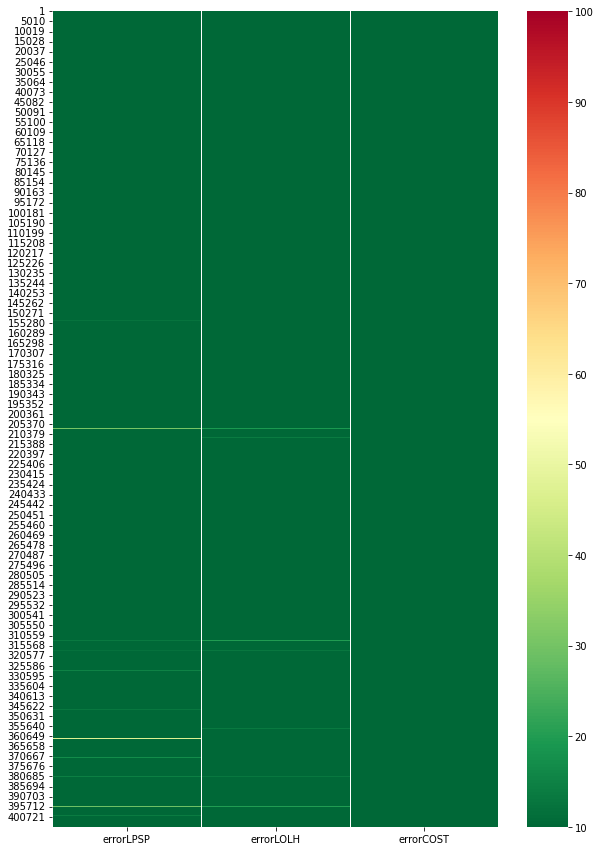

In [110]:
#@markdown # **Resultados**
#@markdown ## - Mapa de calor del Error Relativo entre el dataset original y el obtenido

real = dataset.iloc[:, 4:7].values

def error_relativo(y_true, y_modelo):
    error = np.abs(y_true - y_modelo) / y_true * 100
    return error

predictArray = predict.flatten(order="C")
realArray = real.flatten(order="C")
relativoArray = error_relativo(realArray, predictArray)
relativo = relativoArray.reshape(len(dataset), 3)
puntos = dataset.iloc[:, 7:8].values.transpose()

errorDataset = pd.DataFrame(
    relativo,
    columns = ["errorLPSP", "errorLOLH", "errorCOST"],
    index = puntos[0]
)
import seaborn as sns
plt.subplots(figsize=(10, 15))
ax = sns.heatmap(errorDataset, vmin=10, vmax=100, cmap="RdYlGn_r");

In [111]:
#@markdown # **Posición usando filtrado**
#@markdown ## - Filtrado de posiciones con respecto a los valores maximos y minimos de LPSP y LOLH
predictDataset = pd.DataFrame(
    predict,
    columns = ["LPSP", "LOLH", "COST"],
    index = puntos[0]
)
maxLPSP = 2.5 # este valor es porcentual
maxLOLH = 5 # este valor es porcentual
filterRealDataset = dataset[(dataset.LPSP < maxLPSP) & (dataset.LOLH < maxLOLH)]

print("Posicion: ", filterRealDataset.COST.idxmin()+1,
      "\nCOSTO: ", filterRealDataset.COST.min())

Posicion:  108552 
COSTO:  115887.0382


In [112]:
#@markdown ## - Filtrado de la posicion de la combinacion que cumple con las condiciones y presenta el menor costo.

filterDataset = predictDataset[(predictDataset.LPSP <= maxLPSP) & (predictDataset.LOLH <= maxLOLH)]
print("Posicion: ", filterDataset.COST.idxmin(),
      "\nCOSTO: ", filterDataset.COST.min())

Posicion:  108552 
COSTO:  115862.03479100013


In [113]:
#@markdown # **Combinación optima obtenida en el entrenamiento**
#n = 217468 #@param {type:"number"}
n = filterDataset.COST.idxmin()
n -= 1
datosPrediccion = predict[n]
print("\nCantidad de:")
print(" Nd: ", dataset['Nd'][n], "\n", "Nw: ", dataset['Nw'][n], "\n", "Np: ", dataset['Np'][n], "\n", "Nb: ", dataset['Nb'][n], "\n")
print("Datos reales:")
print(" LPSP: ", dataset['LPSP'][n], "\n", "LOLH: ", dataset['LOLH'][n], "\n", "COST: ", dataset['COST'][n], "\n")
print("Datos obtenidos con la predicción:")
print(" LPSP: ", datosPrediccion[0], "\n", "LOLH: ", datosPrediccion[1], "\n", "COST: ", datosPrediccion[2], "\n")

errorLPSP = error_relativo(dataset['LPSP'][n], datosPrediccion[0])
errorLOLH = error_relativo(dataset['LOLH'][n], datosPrediccion[1])
errorCOST = error_relativo(dataset['COST'][n], datosPrediccion[2])

print("Error relativo porcentual")
print(" LPSP: ", errorLPSP, "%\n", "LOLH: ", errorLOLH, "%\n", "COST: ", errorCOST, "%\n")


Cantidad de:
 Nd:  2 
 Nw:  1 
 Np:  76 
 Nb:  12 

Datos reales:
 LPSP:  1.247438553 
 LOLH:  4.952054795 
 COST:  115887.0382 

Datos obtenidos con la predicción:
 LPSP:  1.2526537878099981 
 LOLH:  4.967808219609994 
 COST:  115862.03479100013 

Error relativo porcentual
 LPSP:  0.41807548736214833 %
 LOLH:  0.3181189478335408 %
 COST:  0.02157567350777822 %

